# Import Libraly

In [1]:
import timm
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import numpy as np
import seaborn as sns
import shutil
import matplotlib.pyplot as plt
import os 
import gdown
from tqdm import tqdm
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

In [2]:
url1 = "https://drive.google.com/file/d/1bo6GcbtZoyN9lx32HyhvRjxC6g39oPyW/view?usp=sharing"
url2 = "https://drive.google.com/file/d/1T-deFW_PBmfJ5ClENrxGSbHHTvWJKZjM/view?usp=sharing"
output1 = "/kaggle/working/dataset.zip"
output2 = "/kaggle/working/img_unlabel.zip"
gdown.download(url=url1, output=output1, fuzzy=True)
gdown.download(url=url2, output=output2, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1bo6GcbtZoyN9lx32HyhvRjxC6g39oPyW
From (redirected): https://drive.google.com/uc?id=1bo6GcbtZoyN9lx32HyhvRjxC6g39oPyW&confirm=t&uuid=a18d90aa-4d43-4502-b74f-6862ca58c3d1
To: /kaggle/working/dataset.zip
100%|██████████| 1.30G/1.30G [00:18<00:00, 69.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1T-deFW_PBmfJ5ClENrxGSbHHTvWJKZjM
From (redirected): https://drive.google.com/uc?id=1T-deFW_PBmfJ5ClENrxGSbHHTvWJKZjM&confirm=t&uuid=8a30e366-3b85-4df2-97ac-902c98416ac5
To: /kaggle/working/img_unlabel.zip
100%|██████████| 1.12G/1.12G [00:18<00:00, 60.5MB/s]


'/kaggle/working/img_unlabel.zip'

In [3]:
from zipfile import ZipFile
  
with ZipFile("/kaggle/working/dataset.zip", 'r') as zObject:
      zObject.extractall(
        path='./')

In [4]:
from zipfile import ZipFile
  
with ZipFile("/kaggle/working/img_unlabel.zip", 'r') as zObject:
      zObject.extractall(
        path='./')

# Data preprocessing

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), 
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), shear=15),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Transform สำหรับ validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dir = '/kaggle/working/datasets/Train'
val_dir = '/kaggle/working/datasets/Validation'
test_dir = '/kaggle/working/datasets/Test'

train_dataset = ImageFolder(root=train_dir, transform=train_transform)
val_dataset = ImageFolder(root=val_dir, transform=val_transform)
test_dataset = ImageFolder(root=test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def count_images_per_class(dataset, dataset_name):
    class_names = dataset.classes
    class_counts = Counter(dataset.targets)
    counts = {class_names[idx]: count for idx, count in class_counts.items()}
    
    print(f"\n{dataset_name} Class Distribution:")
    for class_name, count in counts.items():
        print(f"Class {class_name}: {count} images")
    
    return counts, class_names

train_counts, train_class_names = count_images_per_class(train_dataset, "Train")
val_counts, val_class_names = count_images_per_class(val_dataset, "Validation")
test_counts, test_class_names = count_images_per_class(test_dataset, "Test")


Train Class Distribution:
Class Cassava Bacterial Blight (CBB): 700 images
Class Cassava Brown Streak Disease (CBSD): 700 images
Class Cassava Green Mottle (CGM): 700 images
Class Cassava Mosaic Disease (CMD): 700 images
Class Healthy: 700 images

Validation Class Distribution:
Class Cassava Bacterial Blight (CBB): 70 images
Class Cassava Brown Streak Disease (CBSD): 70 images
Class Cassava Green Mottle (CGM): 70 images
Class Cassava Mosaic Disease (CMD): 70 images
Class Healthy: 70 images

Test Class Distribution:
Class Cassava Bacterial Blight (CBB): 200 images
Class Cassava Brown Streak Disease (CBSD): 200 images
Class Cassava Green Mottle (CGM): 200 images
Class Cassava Mosaic Disease (CMD): 200 images
Class Healthy: 200 images


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


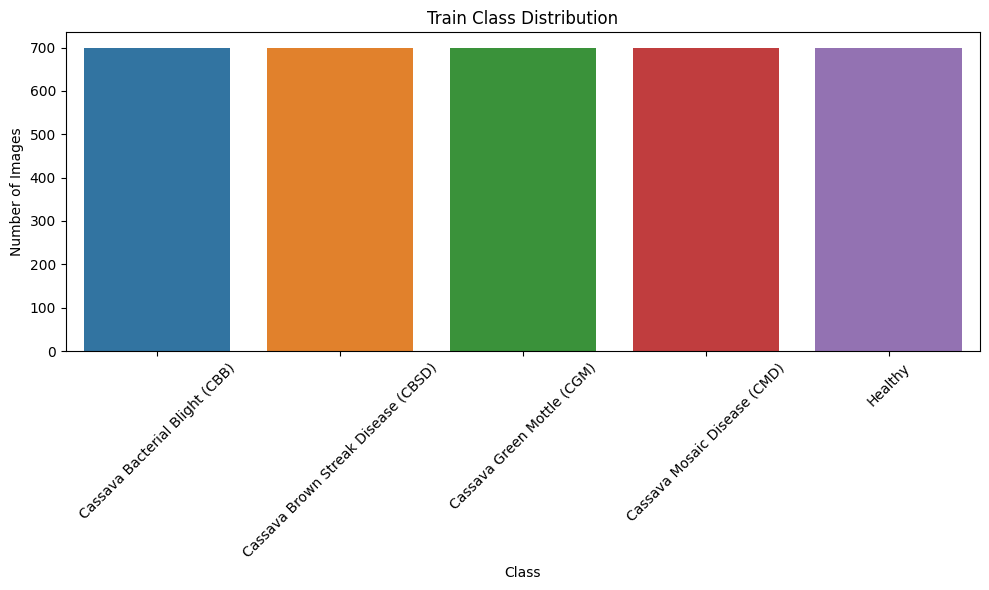

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


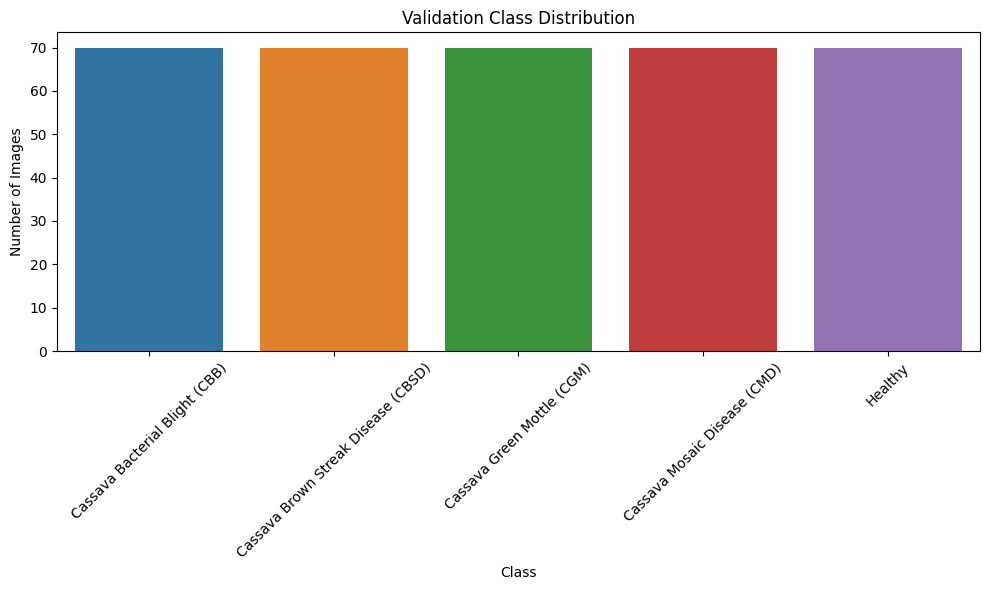

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


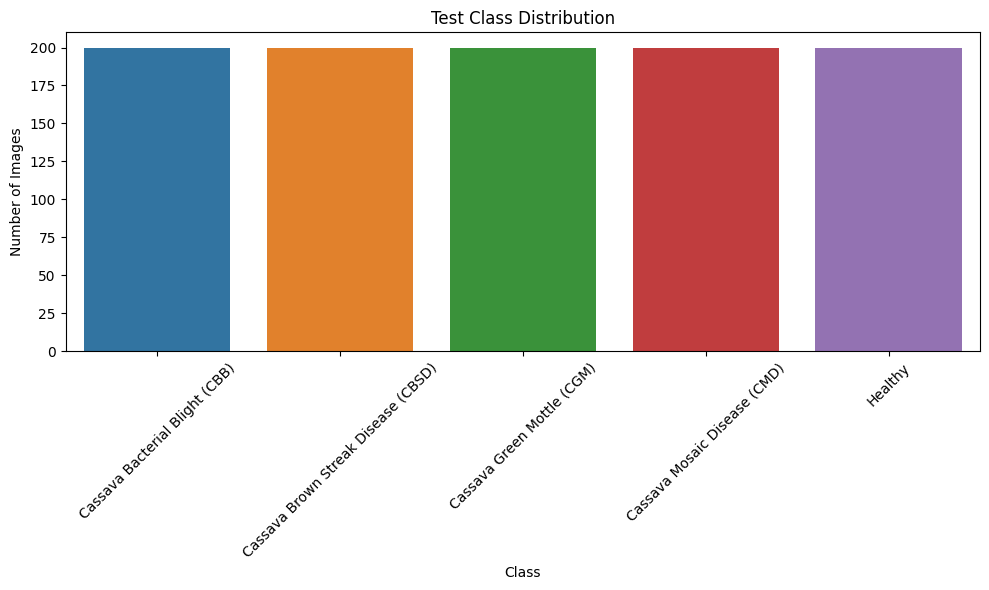

In [7]:
# Plot class
def plot_class_distribution(counts, class_names, dataset_name):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.xticks(rotation=45)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(f'{dataset_name} Class Distribution')
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/{dataset_name.lower()}_class_distribution.png')
    plt.show()

plot_class_distribution(train_counts, train_class_names, "Train")
plot_class_distribution(val_counts, val_class_names, "Validation")
plot_class_distribution(test_counts, test_class_names, "Test")

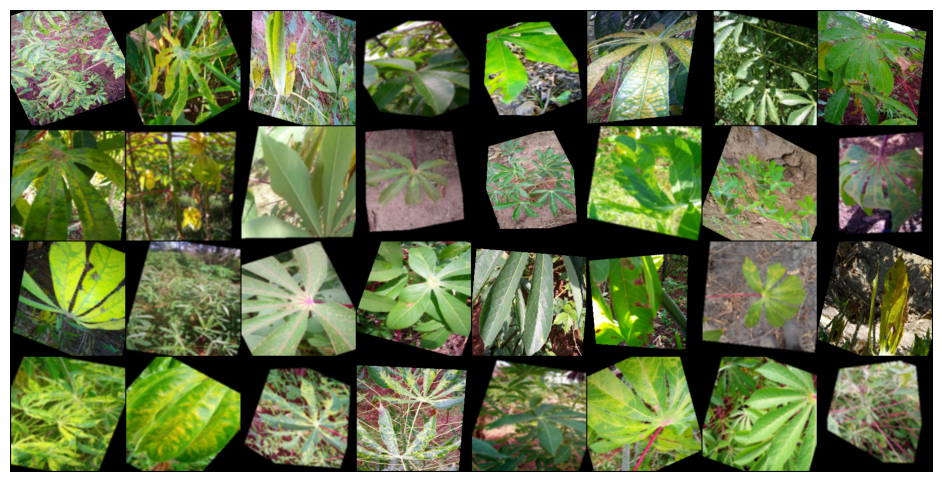

In [8]:
import torchvision
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m) 
    return tensor
data_iter = iter(train_loader)
images, labels = next(data_iter)
denorm_images = torch.stack([denormalize(img.clone(), mean, std) for img in images])

# แปลงเป็น Grid และแสดงผล
img_grid = torchvision.utils.make_grid(denorm_images, nrow=8, padding=2, normalize=False)
plt.figure(figsize=(12, 6))
plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0))) 
plt.axis('off')
plt.show()

# CNN_MODEL

In [9]:
# SE Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Cross-Stage Attention
class CrossStageAttention(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.qkv = nn.Linear(channels, channels * 3)
        self.proj = nn.Linear(channels, 64)
        self.scale = (channels // num_heads) ** -0.5

    def forward(self, x_list):
        B = x_list[0].shape[0]
        feats = [f.view(B, f.shape[1], -1).permute(0, 2, 1) for f in x_list]
        x = torch.cat(feats, dim=1)
        qkv = self.qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.reshape(B, -1, self.num_heads, t.shape[-1]//self.num_heads).permute(0, 2, 1, 3), qkv)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, -1, x.shape[-1])
        return self.proj(x.mean(dim=1))

# Dynamic Feature Reducer
class DynamicFeatureReducer(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1)
        self.se = SEBlock(128)
        self.pool = nn.AdaptiveAvgPool2d((7, 7))

    def forward(self, x):
        x = self.se(self.conv(x))
        return self.pool(x)

# Main Model
class convnextv2_large_model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = timm.create_model('convnextv2_large.fcmae_ft_in22k_in1k', pretrained=True, features_only=True)
        self.backbone.set_grad_checkpointing(True)

        for name, param in self.backbone.named_parameters():
            if 'stages.3' in name or 'norm' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        self.stage_indices = [2, 3]
        self.feature_channels = [self.backbone.feature_info[i]['num_chs'] for i in self.stage_indices]
        self.reducers = nn.ModuleList([DynamicFeatureReducer(c) for c in self.feature_channels])
        self.cross_attention = CrossStageAttention(channels=128)

        self.classifier = nn.Sequential(
            nn.Linear(64, 128),
            nn.GELU(),
            nn.Linear(128, num_classes)
        )
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, x, return_features=False):
        features = self.backbone(x)
        reduced = [self.reducers[i](features[idx]) for i, idx in enumerate(self.stage_indices)]
        x = self.cross_attention(reduced)
        features = self.classifier[:2](x)
        logits = self.classifier[2:](features)
        logits = logits / self.temperature

        if return_features:
            return features
        return logits

# Loss Function

In [10]:
class LabelSmoothedCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1, reduction='mean'):
        super().__init__()
        self.smoothing = smoothing
        self.reduction = reduction

    def forward(self, logits, target):
        log_probs = logits.log_softmax(dim=-1)
        nll = -log_probs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1.0 - self.smoothing) * nll + self.smoothing * smooth_loss
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss)
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def combined_loss(logits, targets):
    ls = LabelSmoothedCrossEntropy(smoothing=0.1, reduction='mean')(logits, targets)
    fl = FocalLoss(gamma=2, reduction='mean')(logits, targets)
    return 0.7 * ls + 0.3 * fl

#  Train

In [11]:
from torch.amp import GradScaler, autocast
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, delta=0, path='checkpoint.pt', verbose=True, monitor='val_loss'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.monitor = monitor
        
        if self.monitor == 'val_loss':
            self.val_score_min = float('inf')
            self.improvement_check = lambda score, best: score < best - self.delta
        else:  # 'val_acc'
            self.val_score_min = -float('inf')
            self.improvement_check = lambda score, best: score > best + self.delta
            
    def __call__(self, val_score, model):
        score = -val_score if self.monitor == 'val_loss' else val_score
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_score, model)
        elif not self.improvement_check(score, self.best_score):
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_score, model)
            self.counter = 0
            
    def save_checkpoint(self, val_score, model):
        if self.verbose:
            score_label = "loss" if self.monitor == "val_loss" else "accuracy"
            print(f'Validation {score_label} improved ({self.val_score_min:.6f} --> {val_score:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_score_min = val_score

# Validation Function
def validate(model, val_loader, device, criterion=None):
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
        
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_pbar = tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            curr_loss = val_loss / total
            curr_acc = 100.0 * correct / total
            val_pbar.set_postfix(loss=f"{curr_loss:.4f}", acc=f"{curr_acc:.2f}%")
    
    return val_loss / total, correct / total

def train_model(model, train_loader, val_loader, device, 
                num_epochs=50, patience=7, delta=0.001, 
                checkpoint_path='best_model.pth', final_model_path='Cassava_convnext_large.pth',
                criterion=None):  
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = GradScaler() 
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    early_stopping = EarlyStopping(patience=patience, delta=delta, path=checkpoint_path, 
                                  verbose=True, monitor='val_acc')
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast('cuda'): 
                outputs = model(images)
                loss = criterion(outputs, labels)  # ใช้ criterion ที่ส่งเข้ามา

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            running_loss += loss.item() * images.size(0)
            total += labels.size(0)
            
            # อัพเดท progress bar 
            curr_loss = running_loss / total
            curr_acc = 100.0 * correct / total
            train_pbar.set_postfix(loss=f"{curr_loss:.4f}", acc=f"{curr_acc:.2f}%")

        # คำนวณและบันทึกค่า train loss และ accuracy
        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation phase
        val_loss, val_acc = validate(model, val_loader, device, criterion)  
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # ใช้ Early Stopping
        early_stopping(val_acc, model)
        
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        scheduler.step()
    
    # โหลดโมเดลที่ดีที่สุด
    model.load_state_dict(torch.load(checkpoint_path))
    
    # บันทึกโมเดลสุดท้าย
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved to {final_model_path}")
    
    actual_epochs = len(history['val_loss'])
    
    return model, history, actual_epochs

In [12]:
def plot_training_history(history, actual_epochs):
    epochs = range(1, actual_epochs + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    plt.close()
    print(f"Training history graph saved as 'training_history.png' (trained for {actual_epochs} epochs)")


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 5
model = convnextv2_large_model(num_classes=num_classes).to(device)
criterion = combined_loss

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])

model.safetensors:   0%|          | 0.00/792M [00:00<?, ?B/s]

Using 2 GPUs!


In [14]:
model, history, actual_epochs = train_model(
    model, 
    train_loader, 
    val_loader, 
    device,
    criterion=criterion,
    num_epochs=100, 
    patience=8, 
    delta=0.001,
    checkpoint_path='best_model.pth', 
    final_model_path='Cassava_convnext_large.pth'
)

Validation: 100%|██████████| 11/11 [00:07<00:00,  1.44it/s, acc=60.29%, loss=1.0443]


Epoch 1/100 | Train Loss: 1.6519 | Train Acc: 0.4106 | Val Loss: 1.0443 | Val Acc: 0.6029
Validation accuracy improved (-inf --> 0.602857). Saving model...


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.39it/s, acc=70.86%, loss=0.8165]


Epoch 2/100 | Train Loss: 0.8509 | Train Acc: 0.6786 | Val Loss: 0.8165 | Val Acc: 0.7086
Validation accuracy improved (0.602857 --> 0.708571). Saving model...


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s, acc=75.43%, loss=0.7320]


Epoch 3/100 | Train Loss: 0.6952 | Train Acc: 0.7791 | Val Loss: 0.7320 | Val Acc: 0.7543
Validation accuracy improved (0.708571 --> 0.754286). Saving model...


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s, acc=83.14%, loss=0.6301]


Epoch 4/100 | Train Loss: 0.6110 | Train Acc: 0.8243 | Val Loss: 0.6301 | Val Acc: 0.8314
Validation accuracy improved (0.754286 --> 0.831429). Saving model...


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s, acc=85.14%, loss=0.5852]


Epoch 5/100 | Train Loss: 0.5647 | Train Acc: 0.8526 | Val Loss: 0.5852 | Val Acc: 0.8514
Validation accuracy improved (0.831429 --> 0.851429). Saving model...


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s, acc=89.43%, loss=0.5194]


Epoch 6/100 | Train Loss: 0.5351 | Train Acc: 0.8706 | Val Loss: 0.5194 | Val Acc: 0.8943
Validation accuracy improved (0.851429 --> 0.894286). Saving model...


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s, acc=90.86%, loss=0.4936]


Epoch 7/100 | Train Loss: 0.5155 | Train Acc: 0.8760 | Val Loss: 0.4936 | Val Acc: 0.9086
Validation accuracy improved (0.894286 --> 0.908571). Saving model...


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.45it/s, acc=90.57%, loss=0.4887]


Epoch 8/100 | Train Loss: 0.4879 | Train Acc: 0.8909 | Val Loss: 0.4887 | Val Acc: 0.9057
EarlyStopping counter: 1 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s, acc=90.29%, loss=0.4725]


Epoch 9/100 | Train Loss: 0.4801 | Train Acc: 0.8929 | Val Loss: 0.4725 | Val Acc: 0.9029
EarlyStopping counter: 2 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.38it/s, acc=89.43%, loss=0.4793]


Epoch 10/100 | Train Loss: 0.4693 | Train Acc: 0.8989 | Val Loss: 0.4793 | Val Acc: 0.8943
EarlyStopping counter: 3 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.40it/s, acc=88.29%, loss=0.4911]


Epoch 11/100 | Train Loss: 0.4598 | Train Acc: 0.9029 | Val Loss: 0.4911 | Val Acc: 0.8829
EarlyStopping counter: 4 out of 8


Validation: 100%|██████████| 11/11 [00:08<00:00,  1.33it/s, acc=90.29%, loss=0.4891]


Epoch 12/100 | Train Loss: 0.4423 | Train Acc: 0.9189 | Val Loss: 0.4891 | Val Acc: 0.9029
EarlyStopping counter: 5 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s, acc=92.00%, loss=0.4445]


Epoch 13/100 | Train Loss: 0.4330 | Train Acc: 0.9183 | Val Loss: 0.4445 | Val Acc: 0.9200
Validation accuracy improved (0.908571 --> 0.920000). Saving model...


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s, acc=88.57%, loss=0.4630]


Epoch 14/100 | Train Loss: 0.4322 | Train Acc: 0.9197 | Val Loss: 0.4630 | Val Acc: 0.8857
EarlyStopping counter: 1 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.45it/s, acc=91.43%, loss=0.4507]


Epoch 15/100 | Train Loss: 0.4243 | Train Acc: 0.9237 | Val Loss: 0.4507 | Val Acc: 0.9143
EarlyStopping counter: 2 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.44it/s, acc=92.29%, loss=0.4379]


Epoch 16/100 | Train Loss: 0.4152 | Train Acc: 0.9277 | Val Loss: 0.4379 | Val Acc: 0.9229
Validation accuracy improved (0.920000 --> 0.922857). Saving model...


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.45it/s, acc=90.29%, loss=0.4656]


Epoch 17/100 | Train Loss: 0.4123 | Train Acc: 0.9289 | Val Loss: 0.4656 | Val Acc: 0.9029
EarlyStopping counter: 1 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.45it/s, acc=91.14%, loss=0.4476]


Epoch 18/100 | Train Loss: 0.4112 | Train Acc: 0.9300 | Val Loss: 0.4476 | Val Acc: 0.9114
EarlyStopping counter: 2 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.45it/s, acc=91.14%, loss=0.4383]


Epoch 19/100 | Train Loss: 0.3935 | Train Acc: 0.9371 | Val Loss: 0.4383 | Val Acc: 0.9114
EarlyStopping counter: 3 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.45it/s, acc=91.43%, loss=0.4298]


Epoch 20/100 | Train Loss: 0.3832 | Train Acc: 0.9420 | Val Loss: 0.4298 | Val Acc: 0.9143
EarlyStopping counter: 4 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.44it/s, acc=92.57%, loss=0.4396]


Epoch 21/100 | Train Loss: 0.3818 | Train Acc: 0.9431 | Val Loss: 0.4396 | Val Acc: 0.9257
Validation accuracy improved (0.922857 --> 0.925714). Saving model...


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s, acc=90.57%, loss=0.4419]


Epoch 22/100 | Train Loss: 0.3776 | Train Acc: 0.9489 | Val Loss: 0.4419 | Val Acc: 0.9057
EarlyStopping counter: 1 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.45it/s, acc=92.57%, loss=0.4277]


Epoch 23/100 | Train Loss: 0.3732 | Train Acc: 0.9474 | Val Loss: 0.4277 | Val Acc: 0.9257
EarlyStopping counter: 2 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.42it/s, acc=92.86%, loss=0.4342]


Epoch 24/100 | Train Loss: 0.3799 | Train Acc: 0.9429 | Val Loss: 0.4342 | Val Acc: 0.9286
Validation accuracy improved (0.925714 --> 0.928571). Saving model...


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s, acc=92.29%, loss=0.4420]


Epoch 25/100 | Train Loss: 0.3793 | Train Acc: 0.9454 | Val Loss: 0.4420 | Val Acc: 0.9229
EarlyStopping counter: 1 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.44it/s, acc=92.29%, loss=0.4298]


Epoch 26/100 | Train Loss: 0.3705 | Train Acc: 0.9509 | Val Loss: 0.4298 | Val Acc: 0.9229
EarlyStopping counter: 2 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.44it/s, acc=92.57%, loss=0.4533]


Epoch 27/100 | Train Loss: 0.3716 | Train Acc: 0.9497 | Val Loss: 0.4533 | Val Acc: 0.9257
EarlyStopping counter: 3 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s, acc=92.00%, loss=0.4511]


Epoch 28/100 | Train Loss: 0.3653 | Train Acc: 0.9534 | Val Loss: 0.4511 | Val Acc: 0.9200
EarlyStopping counter: 4 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.44it/s, acc=92.00%, loss=0.4393]


Epoch 29/100 | Train Loss: 0.3666 | Train Acc: 0.9477 | Val Loss: 0.4393 | Val Acc: 0.9200
EarlyStopping counter: 5 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.38it/s, acc=92.29%, loss=0.4418]


Epoch 30/100 | Train Loss: 0.3609 | Train Acc: 0.9574 | Val Loss: 0.4418 | Val Acc: 0.9229
EarlyStopping counter: 6 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.45it/s, acc=92.29%, loss=0.4487]


Epoch 31/100 | Train Loss: 0.3590 | Train Acc: 0.9577 | Val Loss: 0.4487 | Val Acc: 0.9229
EarlyStopping counter: 7 out of 8


Validation: 100%|██████████| 11/11 [00:07<00:00,  1.43it/s, acc=92.57%, loss=0.4506]
/tmp/ipykernel_19/1501442720.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model

Epoch 32/100 | Train Loss: 0.3557 | Train Acc: 0.9600 | Val Loss: 0.4506 | Val Acc: 0.9257
EarlyStopping counter: 8 out of 8
Early stopping triggered at epoch 32
Final model saved to Cassava_convnext_large.pth


# Plot_Grap_Training

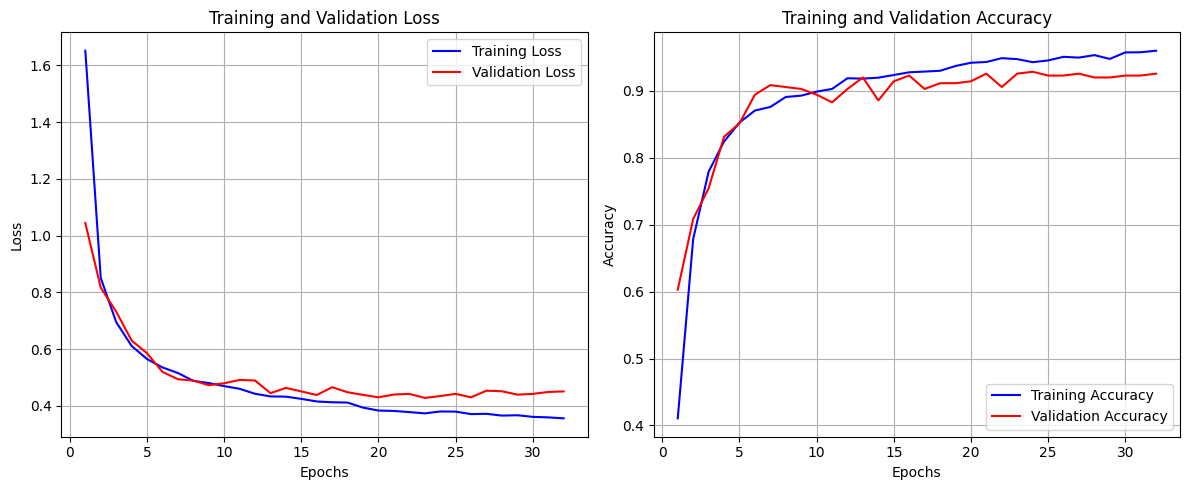

Training history graph saved as 'training_history.png' (trained for 32 epochs)


In [15]:
plot_training_history(history, actual_epochs)

# EVALUATE Confusion Metric and F1 Score

In [16]:
def final_evaluate(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    test_pbar = tqdm(test_loader, desc="Testing")
    with torch.no_grad():
        for images, labels in test_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    # Confusion Matrix
    class_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    plt.close()
    print("Confusion matrix saved as 'confusion_matrix.png'")
    return acc, f1, cm

Testing: 100%|██████████| 32/32 [00:18<00:00,  1.76it/s]


Test Accuracy: 0.9120
Test F1 Score: 0.9115
Classification Report:
              precision    recall  f1-score   support

           0     0.9179    0.9500    0.9337       200
           1     0.9529    0.9100    0.9309       200
           2     0.9588    0.8150    0.8811       200
           3     0.8744    0.9750    0.9220       200
           4     0.8708    0.9100    0.8900       200

    accuracy                         0.9120      1000
   macro avg     0.9150    0.9120    0.9115      1000
weighted avg     0.9150    0.9120    0.9115      1000



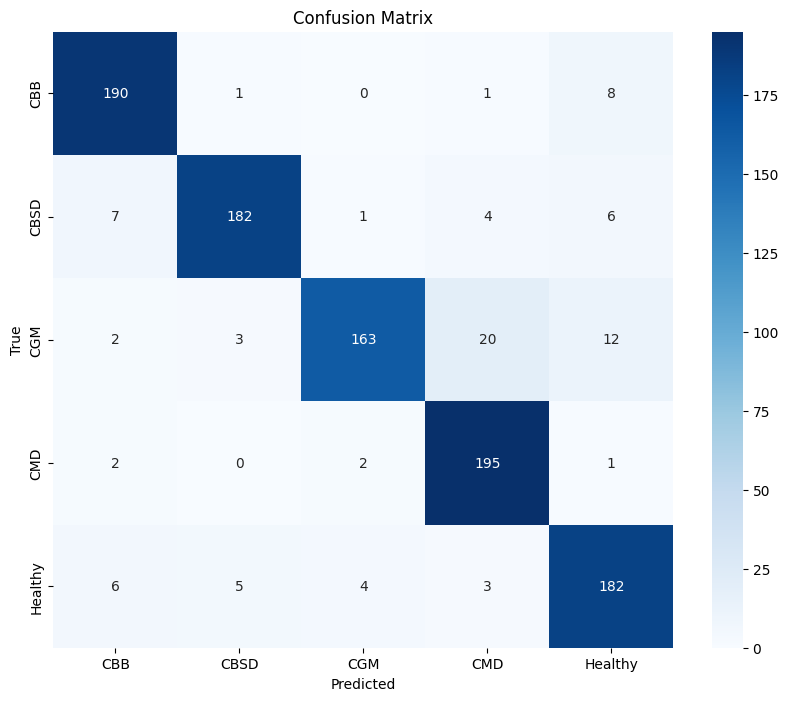

Confusion matrix saved as 'confusion_matrix.png'


In [17]:
test_acc, test_f1, test_cm = final_evaluate(model, test_loader, device)

เปรียบเทียบกับ https://www.kaggle.com/code/pradiptadatta/cassava-leaf-disease-best-quality
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.71      0.65      0.68       311
     Cassava Brown Streak Disease (CBSD)  0.86      0.82      0.84       726
     Cassava Green Mottle (CGM)           0.83      0.79      0.81       632
     Cassava Mosaic Disease (CMD)         0.95      0.97      0.96      3163
                            Healthy       0.76      0.78      0.77       579

                           accuracy                           0.89      5411
                          macro avg       0.82      0.80      0.81      5411
                       weighted avg       0.89      0.89      0.89      5411

# Error Analysis

In [18]:
import os

def show_misclassified_images(model, test_loader, device, class_names, max_images=20, save_dir="misclassified"):
    class_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            wrong = preds != labels
            if wrong.any():
                misclassified_images.extend(images[wrong].cpu())
                misclassified_labels.extend(labels[wrong].cpu())
                misclassified_preds.extend(preds[wrong].cpu())

            if len(misclassified_images) >= max_images:
                break

    # แสดงและบันทึกภาพ
    n_images = min(len(misclassified_images), max_images)
    plt.figure(figsize=(15, 10))
    for i in range(n_images):
        image = misclassified_images[i]
        true_label = class_names[misclassified_labels[i]]
        pred_label = class_names[misclassified_preds[i]]

        # Unnormalize ถ้าจำเป็น (อันนี้ assume ไม่มี mean/std normalization)
        img_np = image.permute(1, 2, 0).numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # normalize [0,1]

        # Plot
        plt.subplot(4, 5, i + 1)
        plt.imshow(img_np)
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
        plt.axis('off')

        # Save รูป
        save_path = os.path.join(save_dir, f"img_{i+1}_true_{true_label}_pred_{pred_label}.png")
        plt.imsave(save_path, img_np)

    plt.tight_layout()
    plt.show()
    print(f"Saved {n_images} misclassified images in '{save_dir}/'")


In [19]:
show_misclassified_images(model, test_loader, device, class_names, max_images=16)

NameError: name 'class_names' is not defined

# Psuedo Labelling

In [ ]:
model.eval()

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import shutil
import timm
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from collections import OrderedDict


# Configuration
class_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']
image_folder = '/kaggle/working/extraimages'                      
model_path = "/kaggle/working/Cassava_convnext_large.pth"    
output_folder = 'pseudo_labelling_datasets'
confidence_threshold = 0.8  # ลดจาก 0.80 เพื่อให้ได้รูปมากขึ้น

# กำหนดค่า normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# สร้างโฟลเดอร์สำหรับเก็บผลลัพธ์
os.makedirs(output_folder, exist_ok=True)
for name in class_names:
    os.makedirs(os.path.join(output_folder, name), exist_ok=True)

# สร้างโมเดลและโหลด weights
print("กำลังโหลดโมเดล...")
model = convnextv2_large_model(num_classes=len(class_names))

# โหลด weights ด้วยการจัดการข้อผิดพลาดที่ดีขึ้น
try:
    state_dict = torch.load(model_path, map_location='cpu')
    
    # ตรวจสอบว่า state dict ต้องการลบ 'module.' prefix หรือไม่
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")
        new_state_dict[new_key] = v
        
    model.load_state_dict(new_state_dict)
    print("โหลดโมเดลสำเร็จ!")
except Exception as e:
    print(f"เกิดข้อผิดพลาดในการโหลดโมเดล: {e}")
    # ลองแสดง key ที่มีใน state dict
    if 'state_dict' in state_dict:
        print("พบ 'state_dict' key ในไฟล์โมเดล")
        state_dict = state_dict['state_dict']
    
    print(f"Keys ในโมเดล: {list(state_dict.keys())[:5]}...")
    print(f"Keys ที่โมเดลต้องการ: {list(model.state_dict().keys())[:5]}...")
    raise

# กำหนดอุปกรณ์ที่ใช้
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"ใช้อุปกรณ์: {device}")
model = model.to(device)
model.eval()

# การแปลงภาพ
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# ติดตามสถิติ
total_images = len(os.listdir(image_folder))
processed_images = 0
labeled_images = 0
class_distribution = {class_name: 0 for class_name in class_names}

print(f"เริ่มการทำ pseudo-labeling สำหรับ {total_images} รูปภาพ...")

# Pseudo-labeling พร้อมการติดตามความคืบหน้าที่ดีขึ้น
for img_name in tqdm(os.listdir(image_folder), desc="กำลัง Label"):
    img_path = os.path.join(image_folder, img_name)
    processed_images += 1
    
    try:
        img = Image.open(img_path).convert('RGB')
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการเปิด {img_path}: {e}")
        continue
        
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    try:
        with torch.no_grad():
            output = model(img_tensor)
            probs = F.softmax(output, dim=1)
            conf, pred = torch.max(probs, dim=1)
            
        confidence = conf.item()
        predicted_class = class_names[pred.item()]
        
        if confidence >= confidence_threshold:
            label = predicted_class
            target_path = os.path.join(output_folder, label, img_name)
            shutil.copy(img_path, target_path)
            labeled_images += 1
            class_distribution[label] += 1
            
            # แสดงการอัปเดตเป็นระยะ
            if labeled_images % 100 == 0:
                print(f"ติดป้ายแล้ว {labeled_images} รูปภาพ (threshold: {confidence_threshold})")
                
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการประมวลผล {img_path}: {e}")

# แสดงสถิติสรุป
print("\nการทำ Pseudo-labeling เสร็จสิ้น!")
print(f"ประมวลผล {processed_images} รูปภาพ")
print(f"ติดป้ายสำเร็จ {labeled_images} รูปภาพ ({labeled_images/processed_images*100:.2f}%)")
print("\nการกระจายของคลาส:")
for class_name, count in class_distribution.items():
    print(f"  {class_name}: {count} รูปภาพ ({count/labeled_images*100:.2f}% ของรูปที่ติดป้าย)" if labeled_images > 0 else f"  {class_name}: {count} รูปภาพ (0% ของรูปที่ติดป้าย)")

# บันทึกการกระจายเป็น CSV
distribution_df = pd.DataFrame({
    'Class': list(class_distribution.keys()),
    'Count': list(class_distribution.values()),
    'Percentage': [count/labeled_images*100 if labeled_images > 0 else 0 for count in class_distribution.values()]
})
distribution_df.to_csv(os.path.join(output_folder, 'class_distribution.csv'), index=False)
print(f"\nบันทึกการกระจายของคลาสไปที่ {os.path.join(output_folder, 'class_distribution.csv')}")

In [ ]:
shutil.make_archive('/kaggle/working/pseudo_labelling_datasets', 'zip', output_folder)